In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### EuroSAT: Classificação de Uso e Cobertura do Solo com Sentinel-2

![eurosat](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg)

### Introdução

Neste estudo, é abordado o desafio da classificação da cobertura de terras usando imagens de satélite Sentinel-2. As imagens de satélite Sentinel-2 são de acesso aberto e gratuito fornecidas no programa de observação da Terra Copernicus.

O sistema de classificação abre uma porta para uma série de aplicações de observação da Terra podendo ser usado para detectar mudanças no uso e cobertura da terra e como ele pode auxiliar na melhoria dos mapas geográficos.

O conjunto de dados EuroSAT é constituído de 10 classes com 27.000 amostras marcadas e georreferenciadas.

Cada imagem é representada por uma matriz 64 x 64 x 3 (3 canais de cores).


- Link para o dataset: https://github.com/phelber/EuroSAT

###  Tipos de cobertura de solo

- Annual Crop -> Colheita anual
- Forest -> Floresta
- Herbaceous Vegetation -> Vegetação Herbácea
- Highway -> Área Rodoviária
- Industrial -> Área Industrial
- Pasture -> Pasto
- Permanent Crop -> Colheita Permanente
- Residential -> Área Residencial
- River -> Rio
- Sea Lake -> Lago

### Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras import Input
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [4]:
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

### Importação dos dados

In [3]:
ds_train, ds_test = tfds.load('eurosat/rgb',
                               split=['train[:80%]', 'train[80%:]'],
                               as_supervised=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteJGMSIO/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


#### Classes

In [5]:
path_ = '/content/drive/MyDrive/Trabalho - Deep Learning/eurosat/rgb/2.0.0/label.labels.txt'
labels_name = pd.read_csv(path_, header=None)
labels_name.rename(columns={0:'Cobertura_do_Solo'}, inplace=True)
labels_name

,Cobertura_do_Solo
0,Annual Crop
1,Forest
2,Herbaceous Vegetation
3,Highway
4,Industrial
5,Pasture
6,Permanent Crop
7,Residential
8,River
9,Sea Lake


In [6]:
solos = labels_name['Cobertura_do_Solo'].values

In [7]:
# conversão dos dados para numpy arrays
def convert(data):
    return np.array([feature[0].numpy() for feature in data]), np.array([label[1].numpy() for label in data]) 

In [8]:
train_data = convert(ds_train)
test_data = convert(ds_test)

X, y = train_data[0], train_data[1]
X_test, y_test = test_data[0], test_data[1]

#### Info

In [9]:
print(f'Amostras de treino: {len(X)}')
print(f'Amostras de teste: {len(X_test)}')

Amostras de treino: 21600
Amostras de teste: 5400


#### Distribuição por classe

In [10]:
# contagem das classes
unique, counts = np.unique(y, return_counts=True)

# criação do DataFrame
solo_counts = pd.DataFrame({'solo': solos,
                            'contagem': counts})
# ordenação 
solo_counts = solo_counts.sort_values(by='contagem')

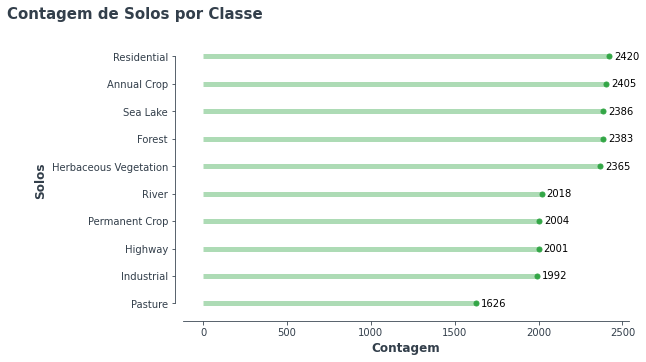

In [56]:
range_=list(range(1, len(solo_counts.index) + 1))

fig, ax = plt.subplots(figsize=(8, 5))
plt.hlines(y=solo_counts['solo'], xmin=0, xmax=solo_counts['contagem'], color='#33a646', alpha=0.4, linewidth=5)
plt.plot(solo_counts['contagem'], solo_counts['solo'], "o", markersize=5, color='#33a646', alpha=1)

for item in list(zip(solo_counts['contagem'], solo_counts['solo'])):
        etiqueta = "{}".format(item[0])
        plt.annotate(etiqueta, (item[0],item[1]) , textcoords="offset points",xytext=(5,5),ha="left",  verticalalignment='top')

# configuração das labels do eixo x e y
ax.set_xlabel('Contagem', fontsize=12, fontweight='black', color = '#333F4B')
ax.set_ylabel('Solos', fontsize=12, fontweight='black', color = '#333F4B')

fig.text(-0.18, 0.95, 'Contagem de Solos por Classe', fontsize=15, fontweight='black', color='#333F4B')

# remoção das linhas do topo e da direita do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((0, len(range_) - 1))

# adiciona espaço entre os eixos e o gráfico
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

### Visualização das imagens e de suas classes

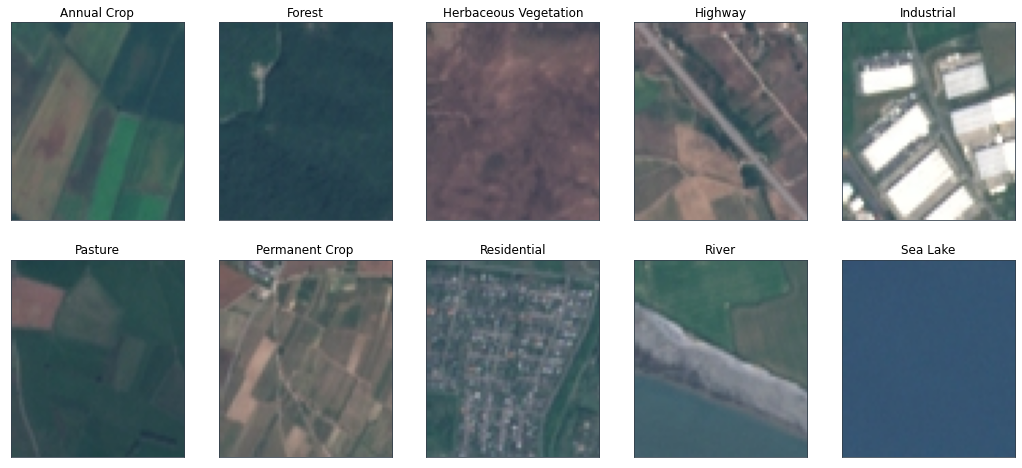

In [55]:
fig = plt.figure(figsize=(18,8))
for i in range(10):
    idx = np.flatnonzero(y == i)[0]
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X[idx])
    ax.set_aspect('auto')
    ax.set_title(solos[i])
plt.savefig(fname='/content/drive/MyDrive/Trabalho - Deep Learning/fig')

#### Divisão dos dados em treino e validação

train/valid/test =  60/20/20

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2)

### VGG16

VGGNet, também conhecida como VGG16, consiste em 16 camadas de peso: 13 camadas convolucionais e 3 camadas totalmente conectadas.



In [ ]:
cnn_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3))

In [ ]:
cnn_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# extração de features
def get_features_vgg16(dataset):
    all_features = []
    for images in dataset:
        preprocessing_images = keras.applications.vgg16.preprocess_input(images)
        features = cnn_base.predict(preprocessing_images.reshape((1, 64, 64, 3)))
        all_features.append(features)
    return np.concatenate(all_features)

In [ ]:
X_train_ = get_features_vgg16(X_train)
X_valid_ = get_features_vgg16(X_valid)

#### Treino

In [ ]:
model_vgg1 = Sequential()
model_vgg1.add(Input(shape=(2,2, 512))) 
model_vgg1.add(Flatten())
model_vgg1.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                     bias_regularizer=regularizers.l2(1e-4)))
model_vgg1.add(tf.keras.layers.BatchNormalization())
model_vgg1.add(Dropout(0.5))
model_vgg1.add(tf.keras.layers.BatchNormalization())
model_vgg1.add(Dense(10, activation='softmax'))

In [ ]:
model_vgg1.compile(loss="sparse_categorical_crossentropy", 
                   optimizer='rmsprop', 
                   metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Trabalho - Deep Learning/model_vgg1.weights.best.hdf5', 
                               verbose=1,
                              save_best_only=True)

In [ ]:
hist = model_vgg1.fit(X_train_, y_train, 
                     batch_size=32, 
                    epochs=50, 
                    callbacks=[checkpointer], 
                    validation_data=(X_valid_, y_valid))

In [ ]:
plt.style.use('ggplot')
def loss_acc_plot(hist, metric):
  plt.figure(figsize=(12, 7))
  epochs = range(1, 51)
  train_data_vl = hist.history[metric]
  validation_data_vl = hist.history['val_' + metric]
  plt.plot(epochs,  train_data_vl, '-o',label='Train Data', c='g')
  plt.plot(epochs, validation_data_vl, '-o', label='Validation Data', c='r')
  plt.legend()
  plt.xticks(range(0, 51, 5))
  plt.yticks(np.arange(0, 1.001, 0.1))

  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel(metric, fontsize=12);

### Curvas de aprendizagem

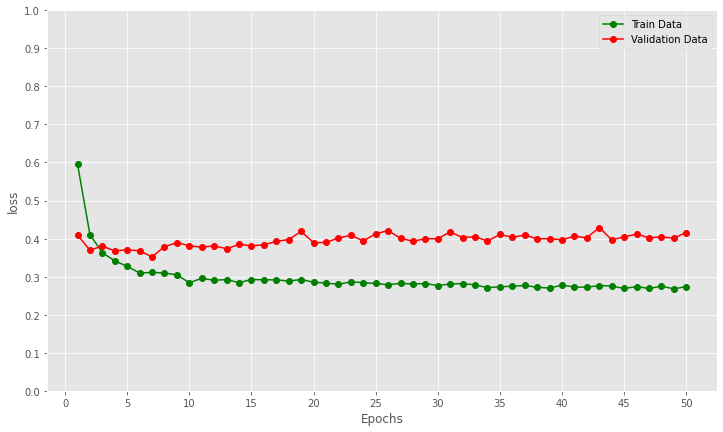

In [ ]:
loss_acc_plot(hist, 'loss')

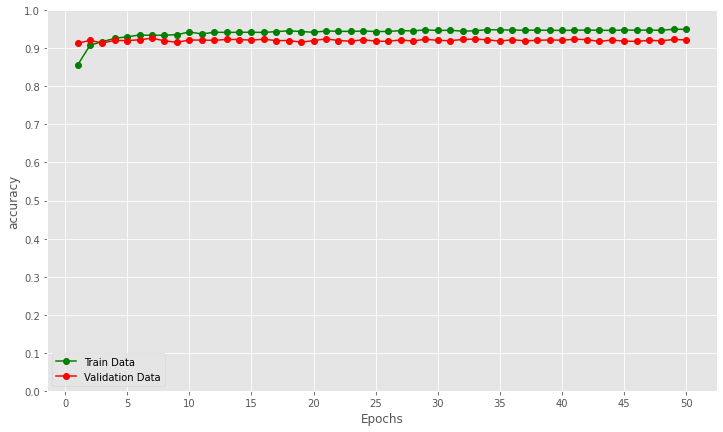

In [ ]:
loss_acc_plot(hist, 'accuracy')

#### Avaliação

In [ ]:
model_path = '/content/drive/MyDrive/Trabalho - Deep Learning/model_vgg1.weights.best.hdf5'
model_vgg1.load_weights(filepath=model_path)

In [ ]:
X_test_ = get_features_vgg16(X_test)

In [ ]:
model_vgg1.evaluate(X_test_, y_test)

169/169 [==============================] - 1s 3ms/step - loss: 0.3523 - accuracy: 0.9263


[0.3523333966732025, 0.9262962937355042]

In [ ]:
y_pred = np.argmax(model_vgg1.predict(X_test_), axis=-1)

#### Precision, Recall e F1-Score

In [ ]:
print(classification_report(y_test, y_pred, target_names=solos))

                       precision    recall  f1-score   support

          Annual Crop       0.92      0.94      0.93       595
               Forest       0.97      0.95      0.96       617
Herbaceous Vegetation       0.92      0.94      0.93       635
              Highway       0.86      0.85      0.86       499
           Industrial       0.94      0.96      0.95       508
              Pasture       0.89      0.92      0.90       374
       Permanent Crop       0.89      0.85      0.87       496
          Residential       0.98      0.94      0.96       580
                River       0.87      0.90      0.88       482
             Sea Lake       0.98      0.97      0.97       614

             accuracy                           0.93      5400
            macro avg       0.92      0.92      0.92      5400
         weighted avg       0.93      0.93      0.93      5400



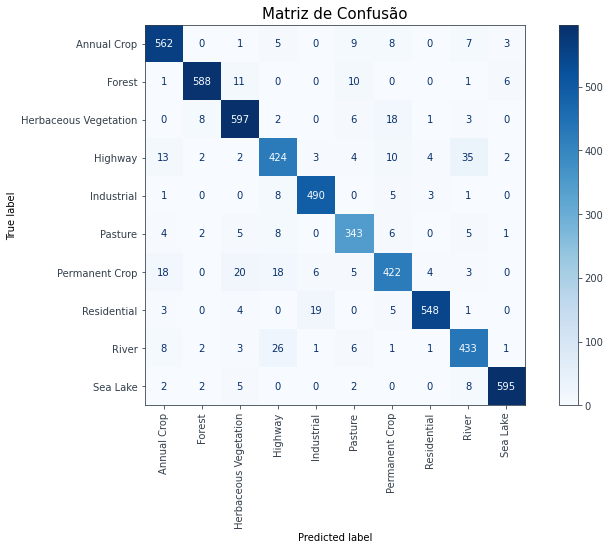

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title('Matriz de Confusão', fontsize=15)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=solos).plot(ax=ax,  cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show();